In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable

############# Declare Strategy Hyperparameters ##################

#Hint: Change the params and run all cell to reach directly to equity curve and performence metrics

RUN_ON_TRAIN_DATA = False   # True for running on training data and False for test data
CONSIDER_ONLY_CLOSE = True  #If False: All crossovers considered using high/low prices instead of close


MA_LENGTH = 40
ST_DEV = 2
SQUEEZE_LOOK_BACK = 25 
SQUEEZE_MEMORY = 50
ATR_LENGTH = 10
ATR_STOP = 5

RISK_FREE_RATE = 0.05  
TRANSACTION_COST = 0.000

The following function takes in a pandas dataframe consisting of daily OHLC and the strategy parameters declared above and returns a dataframe with columns for entry and exit decision making

In [7]:

def preprocess_with_hyperparameters(df,MA_Length,St_Dev,Squeeze_Look_Back,Squeeze_Memory,ATR_Length):
    get_bollinger_bands(df,MA_Length,St_Dev)
    get_BBand_Cross_Signal(df)
    get_volatility_sqeeze_signal(df,Squeeze_Look_Back,Squeeze_Memory)
    get_n_days_ATR(df,ATR_Length)
    df['returns'] = df['Close'].pct_change()
    if(CONSIDER_ONLY_CLOSE):
        TrendExitconditions = [
                (df['Close'].shift(1) <  df['MA'].shift(1)),
                (df['Close'].shift(1) >  df['MA'].shift(1)),
                ]
    else:
        TrendExitconditions = [
                (df['High'].shift(1) <  df['MA'].shift(1)),
                (df['Low'].shift(1) >  df['MA'].shift(1)),
                ]
    TrendExitvalues = [-1,1]

    df['TrendExit'] = 0
    df['TrendExit'] = np.select(TrendExitconditions, TrendExitvalues)
    
    return df
    

In [8]:
def get_n_days_ATR(df,n):
    data = df.copy()
    high = data['High']
    low = data['Low']
    close = data['Close']
    data['tr0'] = abs(high - low)
    data['tr1'] = abs(high - close.shift())
    data['tr2'] = abs(low - close.shift())
    tr = data[['tr0', 'tr1', 'tr2']].max(axis=1)
    atr = tr.rolling(n).mean()
    df['ATR'] = atr
    df.dropna(inplace = True)

    return 

def get_volatility_sqeeze_signal(df,squeeze_look_back,squeeze_memory):
   
    df['IsVolatilitySqueeze'] = 0
    df.loc[df['BandWidth'] <= df['BandWidth'].rolling(squeeze_look_back).min(),'IsVolatilitySqueeze'] = 1
    df.loc[df['IsVolatilitySqueeze'].rolling(squeeze_memory).sum() > 0,'IsVolatilitySqueeze'] = 1
    df.dropna(inplace = True)
    
    return

def get_BBand_Cross_Signal(df):
    if(CONSIDER_ONLY_CLOSE):
        conditions = [
            (df['Close'] <  df['LowerBand']),
            (df['Close'] >  df['UpperBand']),
            ]
    else:
        conditions = [
            (df['High'] <  df['LowerBand']),
            (df['Low'] >  df['UpperBand']),
            ]
    values = [-1, 1]
    df['BandCrossSignal'] = 0
    df['BandCrossSignal'] = np.select(conditions, values)
    df['BandCrossSignal'] = df['BandCrossSignal'].shift(1)
    df.dropna(inplace = True)

    return

def get_bollinger_bands(df,MA_period,band_width):

    df['MA'] = df['Close'].rolling(MA_period).mean()
    df['UpperBand'] = df['MA'] + (df['Close'].rolling(MA_period).std()*band_width)
    df['LowerBand'] = df['MA'] - (df['Close'].rolling(MA_period).std()*band_width)
    df['BandWidth'] = (df['UpperBand'] - df['LowerBand'])/df['MA'] 
    df.dropna(inplace = True)
    
    return   

backtest function takes in a dataframe ready with entry and exit related columns and then a for loop runs through all the rows, taking buy and sell decisions and collecting performence data. Day wise returns are attached in a column named "PortRets" at the end of this function

In [9]:
def backtest(df,ATR_Stop_):
    
    df.reset_index(inplace=True)
    Position = 0
    stop_loss = 0 
    rets = []
    ATR_Stop = ATR_Stop_   #More negative more aggressive
    value_before_trade = 0
    count_trades = 0
    profits_bag = []
    losses_bag = []
    profit_bars = []
    loss_bars = []
    Capital = 100
    trade_start_bar = 0
    for n, row in df.iterrows():

#         if(Position != 0):
#             print(Position,"|",round(row.Close,2),"|",round(stop_loss,2),"|",round(rets[-1],2),"|",row.TrendExit)

        if(Position > 0):
            trade_start_bar += 1
            Capital = (1+row.returns - TRANSACTION_COST)*Capital
            rets.append(Capital)
            if((row.TrendExit < 0) | ((row.Close < stop_loss) & (stop_loss > 0))):
                Position = 0
                stop_loss = 0
                count_trades += 1
                if(Capital > value_before_trade):
                    profits_bag.append(Capital - value_before_trade)
                    profit_bars.append(trade_start_bar)
                    trade_start_bar = 0
                else:
                    losses_bag.append(Capital - value_before_trade)
                    loss_bars.append(trade_start_bar)
                    trade_start_bar = 0        
                    
                
        elif(Position < 0):
            trade_start_bar +=1
            Capital = (1-row.returns - TRANSACTION_COST)*Capital
            rets.append(Capital)
            if((row.TrendExit > 0) | ((row.Close > stop_loss)& (stop_loss > 0))):
                Position = 0
                stop_loss = 0
                count_trades += 1
                if(Capital > value_before_trade):
                    profits_bag.append(Capital - value_before_trade)
                    profit_bars.append(trade_start_bar)
                    trade_start_bar = 0  
                else:
                    losses_bag.append(Capital - value_before_trade)
                    loss_bars.append(trade_start_bar)
                    trade_start_bar = 0            
                  
        else:
            rets.append(Capital)

            if((row.IsVolatilitySqueeze)*(row.BandCrossSignal) > 0):
                Position = 1
                trade_start_bar = 1
                value_before_trade = Capital
                stop_loss = row.Close - (row.ATR*(ATR_Stop))
                
            elif((row.IsVolatilitySqueeze)*(row.BandCrossSignal) < 0):
                Position = -1
                trade_start_bar = 1
                stop_loss = row.Close + (row.ATR*(ATR_Stop))
                value_before_trade = Capital


    df['PortRets'] = 0
    df['PortRets'] = pd.Series(rets)
    return count_trades,profits_bag,losses_bag,profit_bars,loss_bars

Following lines run through all the csv files placed in data/train or data/test folder and backtest on each one of them to create a portfolio at the end and finally provide performence metrics in a pretty table and show a plot of equity vs time for 100 rs as starting value 

TATASTEEL.csv
MARUTI.csv
ULTRACEMCO.csv
ONGC.csv
AXISBANK.csv
HDFCBANK.csv
POWERGRID.csv
MUNDRAPORT.csv
SBIN.csv
+-----------------------------------+--------+------------------------------+
|              Metrics              | Value  |             Unit             |
+-----------------------------------+--------+------------------------------+
|           Strategy CAGR           |  6.28  |         % per annum          |
|          Maximum Drawdown         | -38.88 |              %               |
|     Percent Profitable Trades     | 35.04  |              %               |
| Avg. Win / Avg. Loss amount Ratio |  1.44  |              $               |
|            Sharpe Ratio           |  0.05  |                              |
|       Total Number of Trades      |  548   |            trades            |
|           Winning Trades          |  192   |            trades            |
|           Losing Trades           |  356   |            trades            |
|            Even Trades     

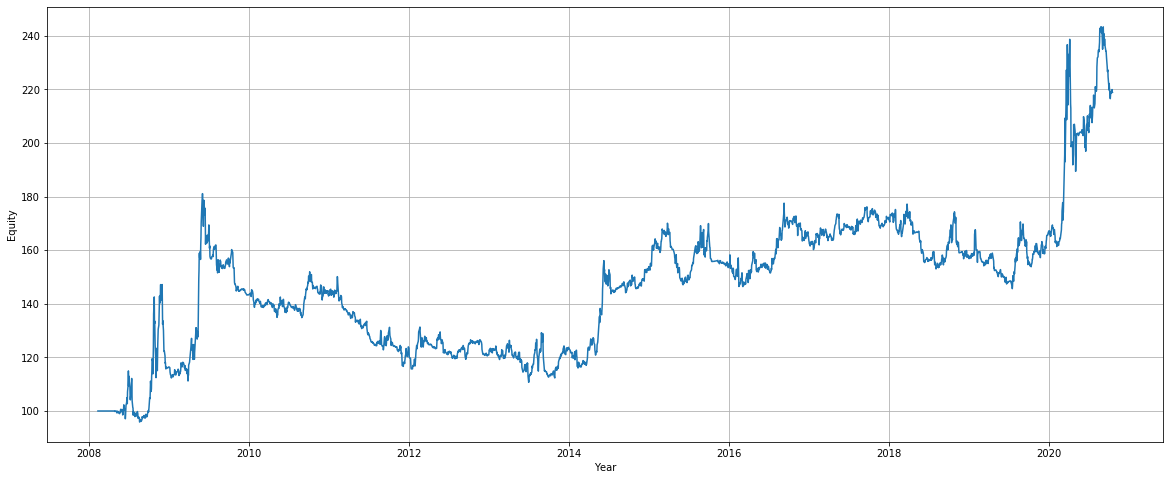

In [10]:

total_trades=0
profits = 0
losses = 0
profitbars = 0
lossbars = 0
port_total_trades = []
port_profits = []
port_losses = []
port_profit_bars = []
port_loss_bars = []

Portfolio = pd.DataFrame()

if(RUN_ON_TRAIN_DATA):
    path = '../iRage_Round_2_Assignment/data/train/'
else:
    path = '../iRage_Round_2_Assignment/data/test/'
    
    
for filename in os.listdir(path):
    if filename.endswith(".csv"): 
        df = pd.read_csv(path + filename)
        df['Date'] = pd.to_datetime(df['Date'],format='%d/%m/%y')

        preprocess_with_hyperparameters(df,MA_LENGTH,ST_DEV,SQUEEZE_LOOK_BACK,SQUEEZE_MEMORY,ATR_LENGTH)
        
        total_trades,profits,losses,profitbars,lossbars = backtest(df,ATR_STOP)
        
        df.set_index(['Date'],inplace=True)
        print(filename)
        Portfolio[filename] = df['PortRets']

        port_total_trades.append(total_trades)
        port_profits.append(profits)
        port_losses.append(losses)
        port_profit_bars.append(profitbars)
        port_loss_bars.append(lossbars)
        
Portfolio.fillna(0,inplace=True)
Portfolio = Portfolio
Portfolio.index = pd.to_datetime(Portfolio.index)

port_profit_bars = [item for sublist in port_profit_bars for item in sublist]
port_loss_bars = [item for sublist in port_loss_bars for item in sublist]
port_profits  = [item for sublist in port_profits for item in sublist]
port_losses  = [item for sublist in port_losses for item in sublist]



testing_period_years = (Portfolio.index[-1] - Portfolio.index[0]).days/360
CAGR = ((Portfolio.sum(axis=1).iloc[-1]/Portfolio.sum(axis=1).iloc[0])**(1/testing_period_years)) - 1 
    
perc_profitable_trades = len(port_profits)/sum(port_total_trades)
win_by_loss_amt_ratio = sum(port_profits)/sum(port_losses)*-1
Total_number_of_trades = sum(port_total_trades)
sharpe_ratio = (CAGR - RISK_FREE_RATE)/(Portfolio.sum(axis=1).std()/(100*len(Portfolio.columns)))

drawdown = ((Portfolio.sum(axis=1) - Portfolio.sum(axis=1).cummax())/Portfolio.sum(axis=1).cummax())
drawdown[drawdown == -np.inf] = 0
max_drawdown = (drawdown.min())

x = PrettyTable()

x.field_names = ["Metrics", "Value", "Unit"]

x.add_row(["Strategy CAGR",round(CAGR*100,2),"% per annum"])
x.add_row(["Maximum Drawdown",round(max_drawdown*100,2),"%"])
x.add_row(["Percent Profitable Trades",round(perc_profitable_trades*100,2),"%"])
x.add_row(["Avg. Win / Avg. Loss amount Ratio",round(win_by_loss_amt_ratio,2),"$"])
x.add_row(["Sharpe Ratio",round(sharpe_ratio,2),""])
x.add_row(["Total Number of Trades",Total_number_of_trades,"trades"])
x.add_row(["Winning Trades",len(port_profits),"trades"])
x.add_row(["Losing Trades",len(port_losses),"trades"])
x.add_row(["Even Trades",Total_number_of_trades -len(port_profits) - len(port_losses),"trades"])
x.add_row(["Largest Winning Trade",round(max(port_profits),2),"for $100 initial invesetment"])
x.add_row(["Largest Losing Trade",round(min(port_losses),2),"for $100 initial invesetment"])
x.add_row(["Avg Bars in Winning Trades",round(sum(port_profit_bars)/len(port_profit_bars),2),"bars"])
x.add_row(["Avg Bars in Losing Trades",round(sum(port_loss_bars)/len(port_loss_bars),2),"bars"])

fig = plt.figure(figsize=(20,8))
ax = fig.gca()

plt.grid()
plt.xlabel("Year")
plt.ylabel("Equity")
plt.plot(Portfolio.sum(axis=1)/(len(Portfolio.columns)))

print(x)
